In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [44]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [45]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [46]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables



/var/folders/lc/58m5rh8x321g_xjyw722cgr80000gn/T/ipykernel_78849/3272935450.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [47]:
# View all of the classes that automap found

classes = Base.classes.keys()
classes


['station', 'measurement']

In [51]:
inspector = inspect(engine)
station_col = inspector.get_columns('station')
for c in station_col:
    print(c['name'], c["type"])

measurement_col = inspector.get_columns('measurement')
for c in measurement_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [42]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


<class 'sqlalchemy.ext.automap.station'>


In [39]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Precipitation Analysis

In [56]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date

('2017-08-23',)

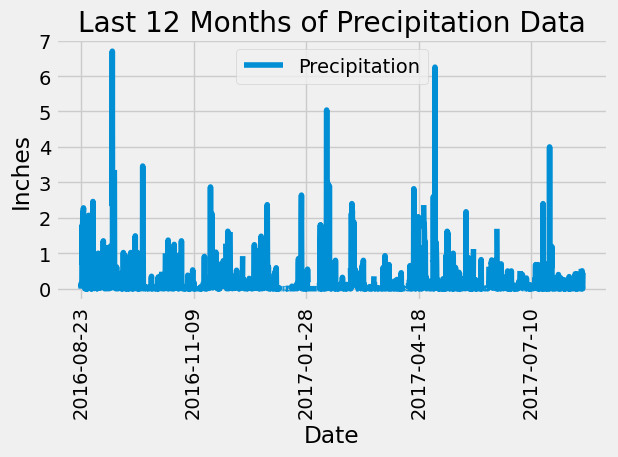

In [74]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
year_ago = date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

prcp_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= year_ago).\
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

prcp_df = pd.DataFrame(prcp_scores, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

prcp_df = prcp_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(x='Date', y='Precipitation', title='Last 12 Months of Precipitation Data', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.yticks(range(0, 8, 1))
plt.tight_layout()
plt.show()

In [75]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [79]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()


[(9,)]

In [81]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [87]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

most_active_id = most_active[0]

most_active_temps = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_id).first()
most_active_temps


(54.0, 85.0, 71.66378066378067)

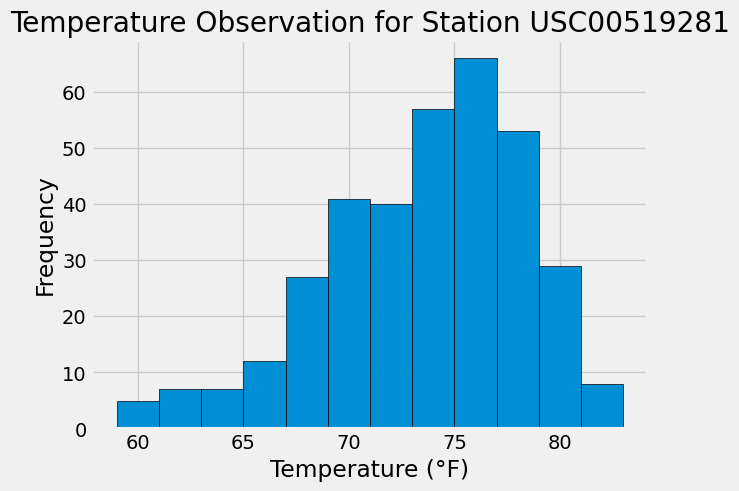

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_id).\
    filter(Measurement.date >= year_ago).all()

temp_df = pd.DataFrame(temp_data, columns=['Date', 'Temperature'])

plt.hist(temp_df['Temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observation for Station {most_active_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()



In [91]:
session.close()